# Electron PSD
author: Louis Richard

Script to plot electron PSD around pitch angles 0, 90, and 180 deg and PSD versus pitch angle L1b brst data 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

from pyrfu import mms, pyrf

Load IGRF coefficients ...


## Define time interval and spacecraft index

In [2]:
mms.db_init("/Volumes/mms")
tint_r = ["2015-10-30T05:15:20.000", "2015-10-30T05:16:20.000"]
mms_id = 1

## Load data

In [3]:
vdf_e = mms.get_data("pde_fpi_brst_l2", tint_r, mms_id)
b_xyz = mms.get_data("b_dmpa_fgm_brst_l2", tint_r, mms_id)
sc_pot = mms.get_data("v_edp_brst_l2", tint_r, mms_id)

[08-Jun-23 18:07:05] INFO: Loading mms1_des_dist_brst...
[08-Jun-23 18:07:05] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/get_dist.py:68: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)

[08-Jun-23 18:07:08] INFO: Loading mms1_fgm_b_dmpa_brst_l2...
[08-Jun-23 18:07:08] INFO: Loading mms1_edp_scpot_brst_l2...


## Convert PSD units to s^3/km^6

In [4]:
vdf_e.data.data *= 1e36

## Resample spacecraft potential to VDF sampling

In [5]:
sc_pot = pyrf.resample(sc_pot, vdf_e.data)

[08-Jun-23 18:07:09] INFO: Using averages in resample


## Produce a single PAD at a selected time

In [6]:
t_pad = "2015-10-30T05:15:45.731587000"

pad_vdf_e = mms.get_pitch_angle_dist(vdf_e, b_xyz, tint=tint_r)
idx_pad = np.argmin(
    np.abs(pad_vdf_e.time.data.astype(int) - np.datetime64(t_pad).astype(int))
)
pad_vdf_e = pad_vdf_e.isel(time=idx_pad)

idx = np.argmin(abs(sc_pot.time.data.astype(int) - np.datetime64(t_pad).astype(int)))
energy_pad = pad_vdf_e.energy.data - sc_pot.data[idx, ...]
thetas_pad = pad_vdf_e.theta.data
pad_data_e = pad_vdf_e.data.data

pad_data_e[pad_data_e == 0.0] = np.nan

[08-Jun-23 18:07:09] INFO: Using averages in resample


## Plot

Text(0.5, 1.0, '05:15:45.731 UT')

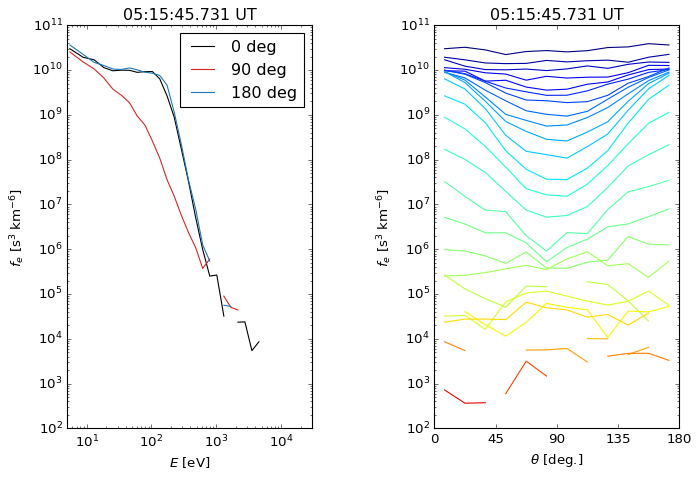

In [7]:
f, axs = plt.subplots(1, 2, figsize=(9, 6))
f.subplots_adjust(hspace=0, wspace=0.5, left=0.1, right=0.95, bottom=0.1, top=0.94)


for i, color, ang in zip([0, 6, -1], ["k", "tab:red", "tab:blue"], [0, 90, 180]):
    axs[0].loglog(energy_pad, pad_data_e[:, i], color=color, label=f"{ang} deg")

axs[0].legend(loc="upper right", frameon=True)
axs[0].set_xlim([5, 3e4])
axs[0].set_xlabel("$E$ [eV]")
axs[0].set_ylim([10**2, 10 ** np.ceil(np.nanmax(np.nanmax(np.log10(pad_data_e))))])
axs[0].set_ylabel("$f_e$ [s$^3$ km$^{-6}$]")
axs[0].set_title("{} UT".format(t_pad[11:23]))

colors = pl.cm.jet(np.linspace(0, 1, len(energy_pad)))

for (i, energy), color in zip(enumerate(energy_pad), colors):
    axs[1].semilogy(thetas_pad, pad_data_e[i, :], color=color)

axs[1].set_xlim([0, 180])
axs[1].set_xticks([0, 45, 90, 135, 180])
axs[1].set_xlabel("$\\theta$ [deg.]")
axs[1].set_ylim([10**2, 10 ** np.ceil(np.nanmax(np.nanmax(np.log10(pad_data_e))))])
axs[1].set_ylabel("$f_e$ [s$^3$ km$^{-6}$]")
axs[1].set_title("{} UT".format(t_pad[11:23]))